In [3]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import os
import pipes_sys

from BNS_JT import cpm, variable

# Results of general B&B algorithm to reliability analysis

Incomplete branch and bound, deterministic inference by bounding, and indepdent components

# Problem

## Pipeline plant system

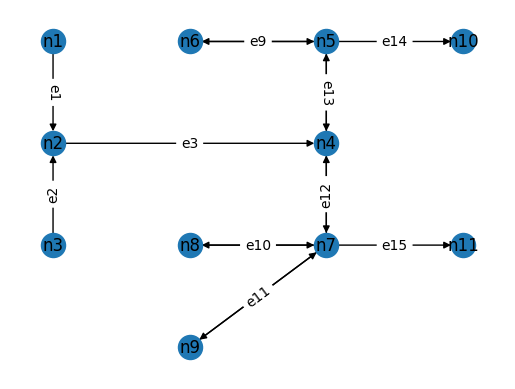

In [9]:
HOME = os.getcwd()

node_coords = {'n1': (0, 1),
                'n2': (0, 0),
                'n3': (0, -1),
                'n4': (2, 0),
                'n5': (2, 1),
                'n6': (1, 1),
                'n7': (2, -1),
                'n8': (1, -1),
                'n9': (1, -2),
                'n10': (3, 1),
                'n11': (3, -1)}

no_node_st = 2 # Number of a node's states
node_st_cp = [0, 2] # state index to actual capacity (e.g. state 1 stands for flow capacity 2, etc.)
varis = {}
for k, v in node_coords.items():
    varis[k] = variable.Variable( name=k, B = np.eye( no_node_st ), values = node_st_cp )

edges = {'e1': ['n1', 'n2'],
        'e2': ['n3', 'n2'],
        'e3': ['n2', 'n4'],
        'e4': ['n4', 'n5'],
        'e5': ['n5', 'n6'],
        'e6': ['n4', 'n7'],
        'e7': ['n7', 'n8'],
        'e8': ['n7', 'n9'],
        'e9': ['n6', 'n5'],
        'e10': ['n8', 'n7'],
        'e11': ['n9','n7'],
        'e12': ['n7','n4'],
        'e13': ['n5','n4'],
        'e14': ['n5','n10'],
        'e15': ['n7','n11'],
        'e16': ['n4', 'n5'],
        'e17': ['n4', 'n7']}

edges2comps = {} # mapping between edges and component events
comps2edges = {}
c_idx = 0
for e, pair in edges.items():
    c_idx += 1
    edges2comps[e] = 'x' + str(c_idx)
    comps2edges[ 'x' + str(c_idx) ] = e

no_comp = c_idx
    

es_idx = { }
idx = 0
for e in edges:
    idx += 1
    es_idx[e] = idx

no_comp_st = 3 # Number of a comp's states
comp_st_fval = [0, 1, 2] # state index to actual flow capacity (e.g. state 1 stands for flow capacity 0, etc.)
for e, x in edges2comps.items():
    if x not in varis:
        varis[x] = variable.Variable( name=x, B = np.eye( no_comp_st ), values = comp_st_fval )

# subsystems information
sub_bw_nodes = [['n1', 'n2', 'n3', 'n4', 'n5', 'n6', 'n7', 'n8', 'n9'],
                ['n4', 'n5', 'n6', 'n7', 'n8', 'n9', 'n10', 'n11']] # nodes in between subsystem i and (i+1)
sub_bw_edges = [['e1', 'e2', 'e3', 'e4', 'e5', 'e6', 'e7', 'e8'],
                ['e16','e17','e9','e10','e11','e12','e13','e14','e15']]

no_sub = len(sub_bw_nodes) + 1

depots = [['n1', 'n3'], ['n6', 'n8', 'n9'], ['n10', 'n11']] # nodes that flows must stop by

thres = 2 # Threhold of system failure event (minimum flow to be processed)


# Plot the system
G = nx.DiGraph()
for k, x in edges.items():
    G.add_edge(x[0], x[1], label=k)

for k, v in node_coords.items():
    G.add_node(k, pos=v, label = k)

pos = nx.get_node_attributes(G, 'pos')
edge_labels = nx.get_edge_attributes(G, 'label')

fig = plt.figure()
ax = fig.add_subplot()
nx.draw(G, pos, with_labels=True, ax=ax)
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, ax=ax)
fig.savefig( os.path.join(HOME, 'graph_toy.png'), dpi=200)



## Events: Independent component events

In [10]:
cpms = {}

# Component events
for k in node_coords:
    cpms[k] = cpm.Cpm( variables=[ varis[k] ], no_child = 1, C = np.array([0,1]), p = [0.1, 0.9] )

for e, x in edges2comps.items():
    cpms[x] = cpm.Cpm( [ varis[x] ], no_child = 1, C = np.array([0,1,2]), p = [0.1, 0.2, 0.7] )


# Damage observation
C_o = np.array([[1,1], [2,1], [1,2], [2,2]])-1
p_o = np.array([0.95, 0.05, 0.1, 0.9]).T
for (i,k) in enumerate(node_coords):
    name = 'on' + str(i+1)
    varis[name] = variable.Variable( name=name, B = np.eye( 2 ), values = [0,1] ) # observation that n_i = 0 or 1 ** TO DISCUSS: probably values in dictionary..?
    cpms[name] = cpm.Cpm( variables=[ varis[name], varis[k] ], no_child = 1, C = C_o, p = p_o )

C_o = np.array([[1,1], [2,1], [3,1], [1,2], [2,2], [3,2], [1,3], [2,3], [3,3]])-1
p_o = np.array([0.95, 0.04, 0.01, 0.3, 0.5, 0.2, 0.01, 0.19, 0.8]).T
for (i,k) in enumerate(comps2edges):
    name = 'ox' + str(i+1)
    varis[name] = variable.Variable( name=name, B = np.eye( 3 ), values = [0,1,2] ) # observation that x_i = 0, 1, or 2 ** TO DISCUSS: probably values in dictionary..?
    cpms[name] = cpm.Cpm( variables=[ varis[name], varis[k] ], no_child = 1, C = C_o, p = p_o )


print(cpms['x1'])
print(cpms['ox1'])

Cpm(variables=['x1'], no_child=1, C=[[0]
 [1]
 [2]], p=[[0.1]
 [0.2]
 [0.7]]
Cpm(variables=['ox1', 'x1'], no_child=1, C=[[0 0]
 [1 0]
 [2 0]
 [0 1]
 [1 1]
 [2 1]
 [0 2]
 [1 2]
 [2 2]], p=[[0.95]
 [0.04]
 [0.01]
 [0.3 ]
 [0.5 ]
 [0.2 ]
 [0.01]
 [0.19]
 [0.8 ]]


# System event quantification by general B&B algorithm

## System function

In [11]:
def sys_fun_pipes( comps_st, thres, edges, node_coords, es_idx, edges2comps, depots, varis, sub_bw_nodes, sub_bw_edges ):
    res = pipes_sys.run_pipes_fun( comps_st, edges, node_coords, es_idx, edges2comps, depots, varis, sub_bw_nodes, sub_bw_edges )

    if res.success == True:
        sys_val = -res.fun
    else:
        sys_val = 0
    
    if sys_val < thres:
        sys_st = 'fail'
    else:
        sys_st = 'surv'
    

    if sys_st == 'surv':

        min_comps_st = {}
        for e, pair in edges.items():
            
            e_idx = es_idx[e]

            if res.x[ e_idx ] > 0:
                x_name = edges2comps[e]

                if x_name not in min_comps_st:
                    x_st = comps_st[x_name]

                    min_comps_st[x_name] = x_st

                if pair[0] not in min_comps_st:
                    n_st = comps_st[pair[0]]
                    min_comps_st[pair[0]] = n_st

                if pair[1] not in min_comps_st:
                    n_st = comps_st[pair[1]]
                    min_comps_st[pair[1]] = n_st

    else:
        min_comps_st = None

    return sys_val, sys_st, min_comps_st




In [15]:
thres = 2 # Threhold of system failure event (minimum flow to be processed)
sys_fun = lambda comps_st : sys_fun_pipes( comps_st, thres, edges, node_coords, es_idx, edges2comps, depots, varis, sub_bw_nodes, sub_bw_edges )

## Branch and Bound: complete results, i.e. no unknown branches

In [31]:
import copy
import gen_bnb

varis_comp = {}
for k in [k for k in node_coords]+[ k for k in comps2edges ]:
    varis_comp[k] = copy.deepcopy( varis[k] )
    

no_sf, rules, rules_st, brs, sys_res = gen_bnb.do_gen_bnb( sys_fun, varis_comp, max_br=1000 ) # Complete 

[Iteration 1]..
The # of found non-dominated rules: 0
The # of branches: 0
---
go next iteration: 2.0
[Iteration 2]..
The # of found non-dominated rules: 1
The # of branches: 0
---
go next iteration: -0.0
[Iteration 3]..
The # of found non-dominated rules: 2
The # of branches: 0
---
go next iteration: 2.0
[Iteration 4]..
The # of found non-dominated rules: 3
The # of branches: 0
---
go next iteration: -0.0
[Iteration 5]..
The # of found non-dominated rules: 3
The # of branches: 0
---
go next iteration: -0.0
[Iteration 6]..
The # of found non-dominated rules: 4
The # of branches: 1
---
go next iteration: 1.0
[Iteration 7]..
The # of found non-dominated rules: 4
The # of branches: 1
---
go next iteration: -0.0
[Iteration 8]..
The # of found non-dominated rules: 5
The # of branches: 2
---
go next iteration: -0.0
[Iteration 9]..
The # of found non-dominated rules: 5
The # of branches: 2
---
go next iteration: -0.0
[Iteration 10]..
The # of found non-dominated rules: 6
The # of branches: 3


KeyboardInterrupt: 

# System Reliability Analysis

## Quantification of system events

In [22]:
import importlib
importlib.reload(gen_bnb)

<module 'gen_bnb' from 'C:\\Users\\jb622s\\git\\BNS-JT\\BNS_JT\\gen_bnb.py'>

In [24]:
from gen_bnb import get_compsite_state, get_Csys_from_brs

st_br_to_cs = {'fail': 0, 'surv': 1, 'unk': 2}
Csys, varis = get_Csys_from_brs( brs, varis, st_br_to_cs )

print(Csys)

[[0 2 2 ... 3 3 3]
 [0 2 2 ... 3 3 3]
 [0 2 0 ... 3 3 3]
 ...
 [2 2 1 ... 3 3 3]
 [0 2 1 ... 3 3 3]
 [0 2 1 ... 3 3 3]]


In [25]:
varis['sys'] = variable.Variable( 'sys', np.eye( 3 ), ['fail', 'surv', 'unk'] )

cpm_sys_vname = copy.deepcopy( brs[0].names )
cpm_sys_vname.insert( 0, 'sys' )


cpms['sys'] = cpm.Cpm( variables=[varis[k] for k in cpm_sys_vname], no_child = 1, C = Csys, p = np.ones((len(Csys), 1), int) ) 

## Inference

### Case 1: No observation

In [28]:
var_elim_order_name = ['on'+str(i+1) for i in range(len(node_coords))]+['ox'+str(i+1) for i in range(len(edges))]
var_elim_order_name += [n for n in node_coords] + [x for x in comps2edges]
print(var_elim_order_name)
var_elim_order = [varis[k] for k in var_elim_order_name]

Msys = cpm.variable_elim( [cpms[v] for v in varis.keys()], var_elim_order )
print(Msys) ########## No survival event with 100 branches..!
print( 'Pf_sys (low, up): ', str( Msys.p[ st_br_to_cs['fail'] ] ), str( 1-Msys.p[ st_br_to_cs['surv'] ] ) )

['on1', 'on2', 'on3', 'on4', 'on5', 'on6', 'on7', 'on8', 'on9', 'on10', 'on11', 'ox1', 'ox2', 'ox3', 'ox4', 'ox5', 'ox6', 'ox7', 'ox8', 'ox9', 'ox10', 'ox11', 'ox12', 'ox13', 'ox14', 'ox15', 'ox16', 'ox17', 'n1', 'n2', 'n3', 'n4', 'n5', 'n6', 'n7', 'n8', 'n9', 'n10', 'n11', 'x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7', 'x8', 'x9', 'x10', 'x11', 'x12', 'x13', 'x14', 'x15', 'x16', 'x17']
Cpm(variables=['sys'], no_child=1, C=[[0]
 [2]], p=[[0.53730951]
 [0.07919788]]
Pf_sys (low, up):  [0.53730951] [0.92080212]


## Case 2: Observation

In [30]:
cnd_vars = ['on1', 'ox1']
cnd_states = [1, 1]

Mobs = cpm.condition( [cpms[v] for v in varis.keys()], cnd_vars, cnd_states )
Msys_obs = cpm.variable_elim( Mobs, var_elim_order )



Cpm(variables=['sys'], no_child=1, C=[[0]
 [2]], p=[[0.10366487]
 [0.01585651]]
Pf_sys:  [0.8673333]


In [ ]:
print( sum )